<a href="https://colab.research.google.com/github/nancymahmoud1/Elevvo/blob/main/Traffic_Sign_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

DATA_DIR = os.path.join(path, "Train")
NUM_CLASSES = 43
IMG_SIZE = 32

def load_data():
    data = []
    labels = []

    for class_id in range(NUM_CLASSES):
        class_path = os.path.join(DATA_DIR, str(class_id))
        for img_name in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                data.append(img)
                labels.append(class_id)
            except Exception as e:
                pass

    return np.array(data), np.array(labels)

print("Loading data...")
X, y = load_data()
print("Data loaded:", X.shape, y.shape)


Using Colab cache for faster access to the 'gtsrb-german-traffic-sign' dataset.
Loading data...
Data loaded: (39209, 32, 32, 3) (39209,)


In [4]:
# Normalize and one-hot encode
X = X.astype('float32') / 255.0
y = to_categorical(y, NUM_CLASSES)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Build CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,627 (920.42 KB)

 Trainable params: 235,627 (920.42 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test)
)

Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 56s 114ms/step - accuracy: 0.9905 - loss: 0.0313 - val_accuracy: 0.9935 - val_loss: 0.0304
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 58s 118ms/step - accuracy: 0.9900 - loss: 0.0336 - val_accuracy: 0.9920 - val_loss: 0.0332
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 58s 119ms/step - accuracy: 0.9926 - loss: 0.0255 - val_accuracy: 0.9929 - val_loss: 0.0283
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 51s 104ms/step - accuracy: 0.9924 - loss: 0.0246 - val_accuracy: 0.9935 - val_loss: 0.0246
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 51s 103ms/step - accuracy: 0.9944 - loss: 0.0195 - val_accuracy: 0.9939 - val_loss: 0.0251
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 84s 108ms/step - accuracy: 0.9934 - loss: 0.0219 - val_accuracy: 0.9938 - val_loss: 0.0375
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 81s 107ms/step - accuracy: 0.9940 - loss: 0.0193 - val_accuracy: 0.9950 - val_loss: 0.0204
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 80s 102ms/step - accuracy: 0.9939 - loss: 0

In [8]:
# Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {(accuracy)*100:.4f} %")

246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9961 - loss: 0.0239
Test Accuracy: 99.5409 %


In [14]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

print("Confusion Matrix:")
cm= confusion_matrix(y_true, y_pred_classes)
print(cm)

246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      0.99      0.99       496
           2       0.99      0.99      0.99       450
           3       1.00      0.99      0.99       280
           4       1.00      1.00      1.00       418
           5       0.99      1.00      0.99       364
           6       1.00      1.00      1.00        59
           7       1.00      0.99      1.00       278
           8       1.00      1.00      1.00       301
           9       1.00      1.00      1.00       268
          10       0.99      1.00      1.00       370
          11       1.00      1.00      1.00       236
          12       1.00      1.00      1.00       450
          13       1.00      1.00      1.00       452
          14       0.99      0.99      0.99       162
          15       1.00      1.00      1.00       120
          16    

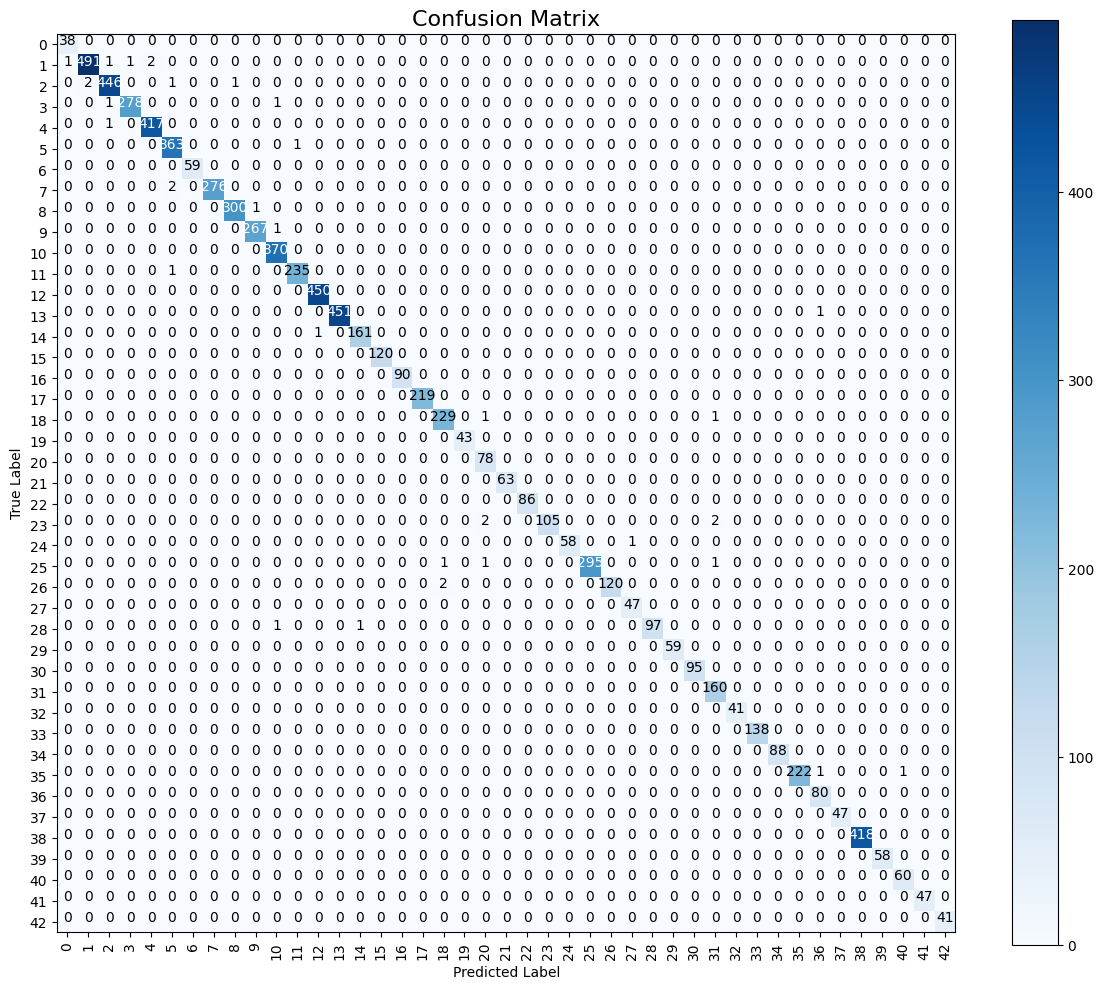

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix", fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))

    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    # Add numbers inside the matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Use class names as strings of their index
class_names = [str(i) for i in range(43)]
plot_confusion_matrix(cm, class_names)


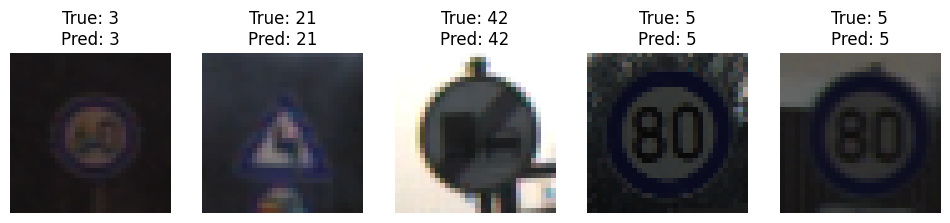

In [11]:
# Visualize Predictions
def show_samples(X, y_true, y_pred, n=5):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        true = y_true[idx]
        pred = y_pred[idx]

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"True: {true}\nPred: {pred}")
        plt.axis('off')
    plt.show()

show_samples(X_test, y_true, y_pred_classes)